# ViT Analysis


## Common Code

In [1]:
import torch
from torch import nn
from torch import Tensor
from einops.layers.torch import Rearrange
import numpy as np
from torch.nn import functional as F
import einops
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Subset
from transformers import ViTForImageClassification, ViTImageProcessor, ViTModel
from PIL import Image
import requests
import random
import os
from numpy.random import choice
import pickle
import math
from itertools import combinations_with_replacement
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import torch.linalg as LA
from collections import defaultdict
from pprint import pprint

/data1/students/anaconda3/envs/sandip-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# Constants
# This model is a fine-tuned version of google/vit-base-patch16-224-in21k on the cifar10 dataset.
PRETRAINED_MODEL_NAME = "aaraki/vit-base-patch16-224-in21k-finetuned-cifar10"
# NOTE: Change this to change layers
MODEL_LAYER = 7

TRAIN_DATA_SIZE = 64
BATCH_SIZE = 64

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [4]:
device = get_default_device()
vit_feature_extractor = ViTImageProcessor.from_pretrained(PRETRAINED_MODEL_NAME)
transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ]
)

In [5]:
dataset = CIFAR10(".", download=True, transform=transform)

Files already downloaded and verified


In [6]:
# Common class for ViT Analysis
class VitForAnalysis(ViTForImageClassification):
    """Common class for getting pretrained values"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @torch.no_grad()
    def get_output_logits(self, x_batch: torch.Tensor):
        op = self.vit(x_batch)
        logits = self.classifier(op[0][:, 0, :])
        return logits.detach().cpu()

    @torch.no_grad()
    def get_last_layer_hidden_state(self, x_batch: torch.Tensor):
        op = self.vit(x_batch)
        return op["last_hidden_state"][:, 0].detach().cpu()

    @torch.no_grad()
    def get_qkv(self, x_batch: torch.Tensor, layer_num: int):
        # If there are 12 layers, valid layer_num is [0, 11]
        op = self.vit.embeddings(x_batch)

        for layer_idx in range(layer_num):
            # till layer number (layer_num - 1)
            op = self.vit.encoder.layer[layer_idx](op)[0]

        q = self.vit.encoder.layer[layer_num].attention.attention.query(op)
        k = self.vit.encoder.layer[layer_num].attention.attention.key(op)
        v = self.vit.encoder.layer[layer_num].attention.attention.value(op)

        return q.detach().cpu(), k.detach().cpu(), v.detach().cpu()

    @torch.no_grad()
    def get_mlp_head_weights(self):
        return self.classifier.weight.detach().cpu()
    

vit_model = to_device(VitForAnalysis.from_pretrained(PRETRAINED_MODEL_NAME), device)

In [7]:
all_data_dict = {
    1: {"label": "car"},
    3: {"label": "cat"},
    9: {"label": "truck"},
}

In [8]:
def get_tensor_from_batch(batch: tuple):
    with torch.no_grad():
        ip_imgs = batch[0]

        inputs = to_device(
            vit_feature_extractor.preprocess(
                images=ip_imgs,
                data_format="channels_first",
                return_tensors="pt",
            )["pixel_values"],
            device,
        )

        return inputs


def get_train_dataloader(class_label: int):
    print("Processing training data for: ", class_label)
    set_seed(200)
    mask_indices = [idx for idx, s in enumerate(dataset) if s[1] == class_label]
    mask_indices = choice(
        mask_indices,
        TRAIN_DATA_SIZE,
        replace=False,
    )
    train_ds = Subset(dataset, mask_indices)
    train_dl = DataLoader(
        train_ds,
        BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    return train_dl

In [9]:
for class_label in all_data_dict.keys():
    train_dl = get_train_dataloader(class_label)
    all_data_dict[class_label]["train_dl"] = train_dl

Processing training data for:  1
Random seed set as 200
Processing training data for:  3
Random seed set as 200
Processing training data for:  9
Random seed set as 200


In [10]:
# Common method to add data to dict from ViT
def add_data(data_key: str, data_fxn):
    # data_key - key to put in dict
    # data_fxn - lambda function that takes in 1 tensor
    # Tensor should be preprocessed
    for class_label in all_data_dict.keys():
        print(f"Processing key {data_key} for label {class_label}")
        with torch.no_grad():
            # Get data
            for batch in all_data_dict[class_label]["train_dl"]:
                ips = get_tensor_from_batch(batch)
                ops = data_fxn(ips)
                all_data_dict[class_label][data_key] = ops
            print(f"Processing complete for class: {class_label}")
            print(f"Inserted key {data_key} into all_data_dict")
            print(
                f"Shape of inserted data: {all_data_dict[class_label][data_key].shape}"
            )

In [11]:
all_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# MLP Head Variation - 1

In [12]:
add_data("logits", vit_model.get_output_logits)

Processing key logits for label 1
Processing complete for class: 1
Inserted key logits into all_data_dict
Shape of inserted data: torch.Size([64, 10])
Processing key logits for label 3
Processing complete for class: 3
Inserted key logits into all_data_dict
Shape of inserted data: torch.Size([64, 10])
Processing key logits for label 9
Processing complete for class: 9
Inserted key logits into all_data_dict
Shape of inserted data: torch.Size([64, 10])


In [13]:
labels = list(all_data_dict.keys())

for i, j in combinations_with_replacement(labels, 2):
    x = torch.mean(all_data_dict[i]["logits"], dim=(0,)).unsqueeze(0)
    y = torch.mean(all_data_dict[j]["logits"], dim=(0,)).unsqueeze(0)

    print(
        f"Logits Between {all_data_dict[i]['label']} and {all_data_dict[j]['label']}",
        f"Euclidean Distance is {LA.vector_norm(x - y): .5f}",
        "",
        sep="\n",
    )

Logits Between car and car
Euclidean Distance is  0.00000

Logits Between car and cat
Euclidean Distance is  0.00590

Logits Between car and truck
Euclidean Distance is  0.00498

Logits Between cat and cat
Euclidean Distance is  0.00000

Logits Between cat and truck
Euclidean Distance is  0.00460

Logits Between truck and truck
Euclidean Distance is  0.00000



Thus
`car-cat > cat-truck > car-truck`

Text(0.5, 1.0, 'MLP head: Weights more than 0.05')

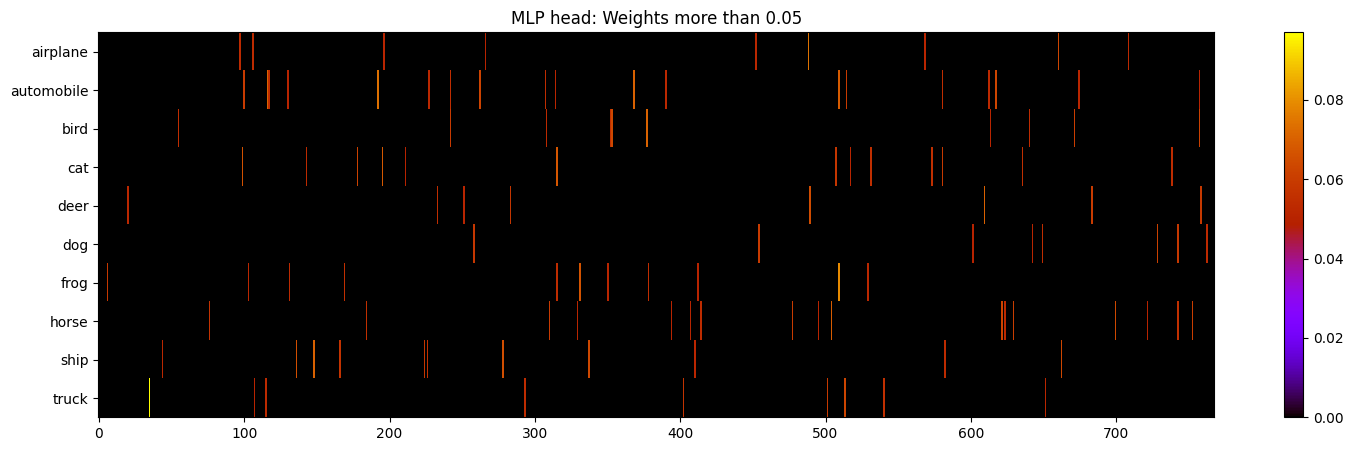

In [14]:
# MLP Head matrix plot - max and min weights
mlp_head = vit_model.get_mlp_head_weights()
lim = 0.05

# Get largest weights mask
mask = mlp_head > lim

plt.figure(figsize=(18, 5))
plt.imshow(mask * mlp_head, interpolation="nearest", aspect="auto", cmap="gnuplot")
plt.yticks(range(10), all_labels)
plt.colorbar()
plt.title(f"MLP head: Weights more than {lim}")

In [15]:
# MLP Head matrix plot - max and min weights
mlp_head = vit_model.get_mlp_head_weights()
lim = 0.05

# Get largest weights mask
masked_mlp = (mlp_head >= lim) * mlp_head

masked_mlp = np.nonzero(masked_mlp)

max_weights_dict = {key: [] for key in range(10)}

for x, y in masked_mlp:
    max_weights_dict[x.item()] += [y.item()]

pprint(max_weights_dict)

{0: [97, 106, 196, 266, 452, 488, 568, 660, 708],
 1: [100,
     116,
     117,
     130,
     192,
     227,
     242,
     262,
     307,
     314,
     368,
     390,
     509,
     514,
     580,
     612,
     617,
     674,
     757],
 2: [55, 242, 308, 352, 353, 377, 613, 640, 671, 757],
 3: [99, 143, 178, 195, 211, 315, 507, 517, 531, 573, 580, 635, 738],
 4: [20, 233, 251, 283, 489, 609, 683, 758],
 5: [258, 454, 601, 642, 649, 728, 742, 762],
 6: [6, 103, 131, 169, 315, 331, 350, 378, 412, 509, 529],
 7: [76,
     184,
     310,
     329,
     394,
     407,
     414,
     477,
     495,
     504,
     621,
     623,
     629,
     699,
     721,
     742,
     752],
 8: [44, 136, 148, 166, 224, 226, 278, 337, 410, 582, 662],
 9: [35, 107, 115, 293, 402, 501, 513, 540, 651]}


Text(0.5, 1.0, 'Distance of each of 10 vector in MLP head to each other')

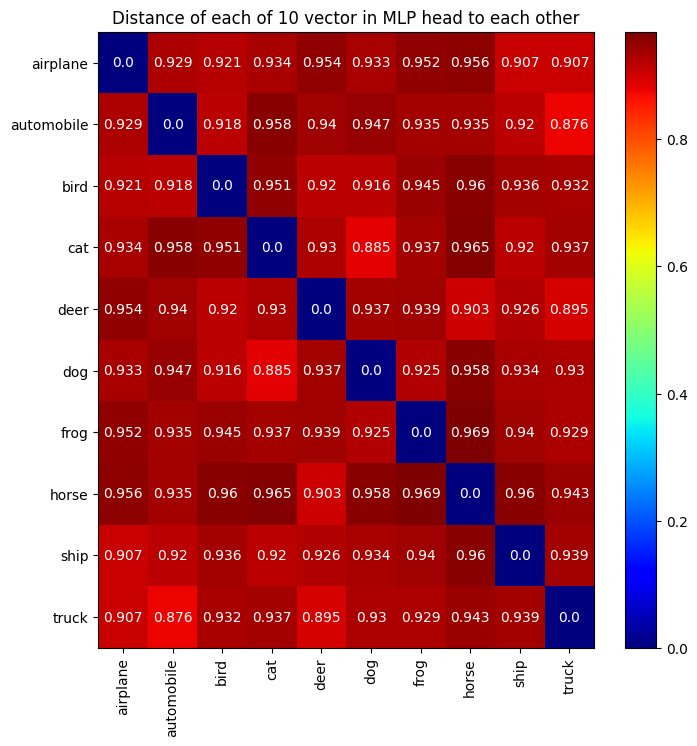

In [16]:
im = euclidean_distances(mlp_head, mlp_head)

plt.figure(figsize=(8, 8))
plt.imshow(im, interpolation="nearest", aspect="auto", cmap="jet")
# plt.bar(np.arange(0, 10), im)
plt.xticks(range(10), all_labels, rotation=90)
plt.yticks(range(10), all_labels)
plt.colorbar()

for i in range(10):
    for j in range(10):
        text = plt.text(j, i, round(im[i, j], 3), ha="center", va="center", color="w")

plt.title("Distance of each of 10 vector in MLP head to each other")

- Cat-Dog distance than smaller than Cat-Any other class distance
- Truck-automobile(car) distance is smaller than any other class

Text(0.5, 1.0, 'Distance of each of 10 vector logits')

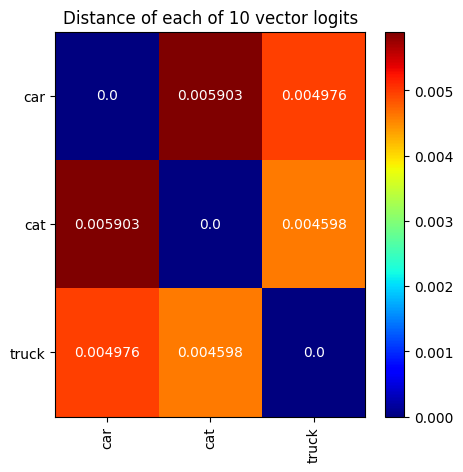

In [17]:
logits_vec = np.array(
    [
        torch.mean(all_data_dict[class_label]["logits"], dim=(0,)).numpy()
        for class_label in labels
    ]
)
im = euclidean_distances(logits_vec, logits_vec)
text_labels = [all_data_dict[class_label]["label"] for class_label in labels]

plt.figure(figsize=(5, 5))
plt.imshow(im, interpolation="nearest", aspect="auto", cmap="jet")

plt.xticks(range(3), text_labels, rotation=90)
plt.yticks(range(3), text_labels)
plt.colorbar()

for i in range(3):
    for j in range(3):
        text = plt.text(j, i, round(im[i, j], 6), ha="center", va="center", color="w")

plt.title("Distance of each of 10 vector logits")

# Analysis 2

`Note - Some code changes might give error in next sections`

# `[class]` token analysis

In [18]:
add_data("cls", vit_model.get_last_layer_hidden_state)

Processing key cls for label 1
Processing complete for class: 1
Inserted key cls into all_data_dict
Shape of inserted data: torch.Size([64, 768])
Processing key cls for label 3
Processing complete for class: 3
Inserted key cls into all_data_dict
Shape of inserted data: torch.Size([64, 768])
Processing key cls for label 9
Processing complete for class: 9
Inserted key cls into all_data_dict
Shape of inserted data: torch.Size([64, 768])


In [19]:
for i, j in combinations_with_replacement(all_data_dict.keys(), 2):
    e1 = all_data_dict[i]["cls"].mean(dim=(0,)).unsqueeze(0)
    e2 = all_data_dict[j]["cls"].mean(dim=(0,)).unsqueeze(0)

    print(
        f"Cosine Similarity: {all_data_dict[i]['label']} and {all_data_dict[j]['label']}: {F.cosine_similarity(e1, e2).item()}"
    )
    print(
        f"Euclidean Distance: {all_data_dict[i]['label']} and {all_data_dict[j]['label']}: {LA.norm(e1 - e2).item()}"
    )
    print()

Cosine Similarity: car and car: 1.0
Euclidean Distance: car and car: 0.0

Cosine Similarity: car and cat: 0.9998973608016968
Euclidean Distance: car and cat: 0.055385373532772064

Cosine Similarity: car and truck: 0.9999064207077026
Euclidean Distance: car and truck: 0.05276131257414818

Cosine Similarity: cat and cat: 1.0
Euclidean Distance: cat and cat: 0.0

Cosine Similarity: cat and truck: 0.9998612403869629
Euclidean Distance: cat and truck: 0.06425123661756516

Cosine Similarity: truck and truck: 0.9999998807907104
Euclidean Distance: truck and truck: 0.0



In [20]:
# fig, axs = plt.subplots(3, sharey=True)

# for idx, label in enumerate(cls_dict.keys()):
#     op = torch.var(cls_dict[label]['cls'], dim=(0, ))
#     axs[idx].plot(op)
#     axs[idx].set_title(f"In Class Variance for [cls] token. Class {cls_dict[label]['label']}", loc='right', fontsize=10)
#     axs[idx].set_xticks([])

# fig.show()

In [21]:
# from sklearn.metrics.pairwise import cosine_similarity

# def get_emb_cosine_similarity(emb_1, emb_2):
#     # embeddings shape: [batch_size, emb_dimension]
#     sim = cosine_similarity(emb_1, emb_2)
#     return sim

In [22]:
# fig ,axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))
# fig.suptitle(f"Pairwise cosine similarity for {TRAIN_DATA_SIZE} samples")

# labels_list = [1, 3, 9]

# for idx_i, idx_j in combinations_with_replacement([0, 1, 2], r=2):
#     v_1 = cls_dict[labels_list[idx_i]]
#     v_2 = cls_dict[labels_list[idx_j]]

#     op = get_emb_cosine_similarity(v_1['cls'], v_2['cls'])

#     axs[idx_i][idx_j].axis('off')
#     axs[idx_i][idx_j].set_title(f"{v_1['label']} v/s {v_2['label']}")
#     im = axs[idx_i][idx_j].imshow(op, cmap='gray_r')

# fig.colorbar(im, ax=axs.ravel().tolist())
# fig.show()

# Q, K, V analysis

In [31]:
# TODO: Change labels name to LAYER_NAME_{q,k,v}

add_data("q", lambda x: vit_model.get_qkv(x, MODEL_LAYER)[0])
add_data("k", lambda x: vit_model.get_qkv(x, MODEL_LAYER)[1])
add_data("v", lambda x: vit_model.get_qkv(x, MODEL_LAYER)[2])

Processing key q for label 1
Processing complete for class: 1
Inserted key q into all_data_dict
Shape of inserted data: torch.Size([64, 197, 768])
Processing key q for label 3
Processing complete for class: 3
Inserted key q into all_data_dict
Shape of inserted data: torch.Size([64, 197, 768])
Processing key q for label 9
Processing complete for class: 9
Inserted key q into all_data_dict
Shape of inserted data: torch.Size([64, 197, 768])
Processing key k for label 1
Processing complete for class: 1
Inserted key k into all_data_dict
Shape of inserted data: torch.Size([64, 197, 768])
Processing key k for label 3
Processing complete for class: 3
Inserted key k into all_data_dict
Shape of inserted data: torch.Size([64, 197, 768])
Processing key k for label 9
Processing complete for class: 9
Inserted key k into all_data_dict
Shape of inserted data: torch.Size([64, 197, 768])
Processing key v for label 1
Processing complete for class: 1
Inserted key v into all_data_dict
Shape of inserted data

In [32]:
def get_attention_from_qkv(q, k, v=None):
    hidden_dim = q.shape[-1]
    attention_scores = torch.matmul(q, k.transpose(-1, -2))

    attention_scores = attention_scores / math.sqrt(hidden_dim // 12)

    # Normalize the attention scores to probabilities.
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)

    if v is not None:
        return torch.matmul(attention_probs, v)
    return attention_probs


def var_reduce(t, dims=(0,)):
    return torch.var(t, dim=dims, keepdim=True)[0]

## Self Attention

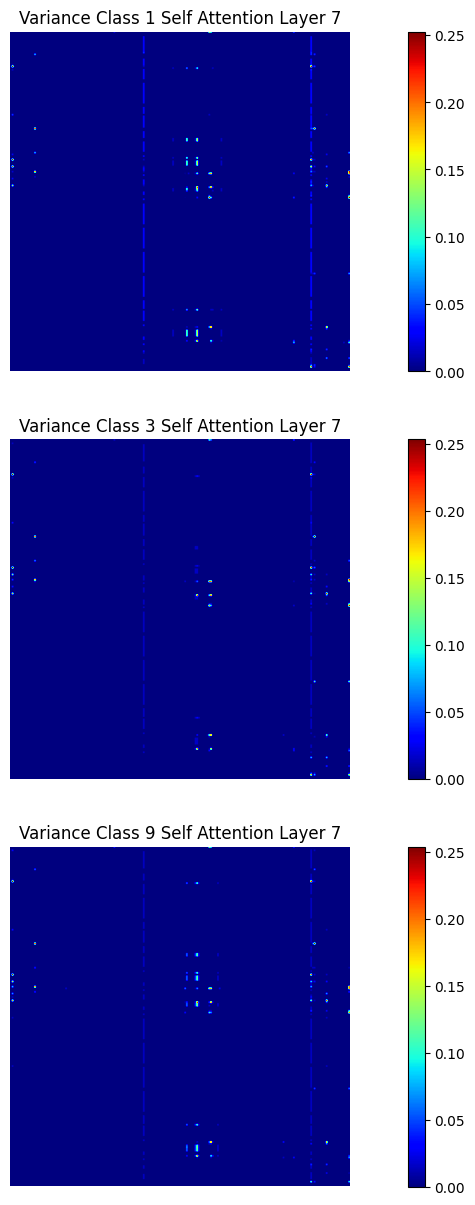

In [33]:
fig, axs = plt.subplots(3, figsize=(15, 15))

for idx, i in enumerate(all_data_dict.keys()):
    x = get_attention_from_qkv(all_data_dict[i]["q"], all_data_dict[i]["k"])
    x = torch.var(x, dim=0)

    axs[idx].title.set_text(f"Variance Class {i} Self Attention Layer {MODEL_LAYER}")
    axs[idx].axis("off")

    im = axs[idx].imshow(x, cmap="jet")
    plt.colorbar(im, ax=axs[idx])

## Cross Attention

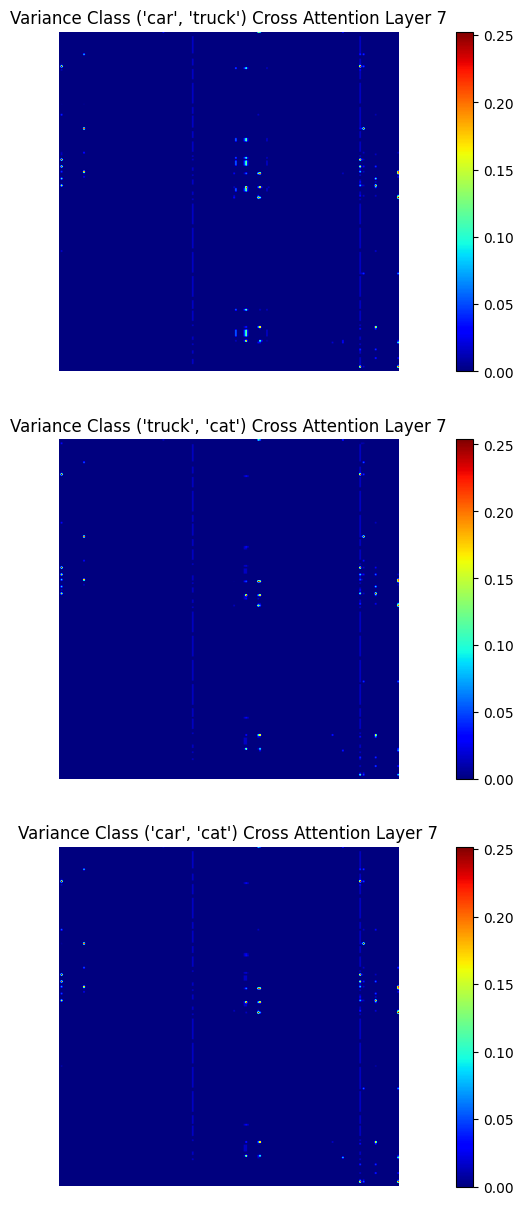

In [34]:
fig, axs = plt.subplots(3, figsize=(15, 15))

# (car, truck), (truck, cat), (car, cat)
for idx, (i, j) in enumerate([(1, 9), (9, 3), (1, 3)]):
    x = get_attention_from_qkv(all_data_dict[i]["q"], all_data_dict[j]["k"])
    x = torch.var(x, dim=0)

    axs[idx].title.set_text(
        f"Variance Class {all_data_dict[i]['label'], all_data_dict[j]['label']} Cross Attention Layer {MODEL_LAYER}"
    )
    axs[idx].axis("off")

    im = axs[idx].imshow(x, cmap="jet")
    plt.colorbar(im, ax=axs[idx])

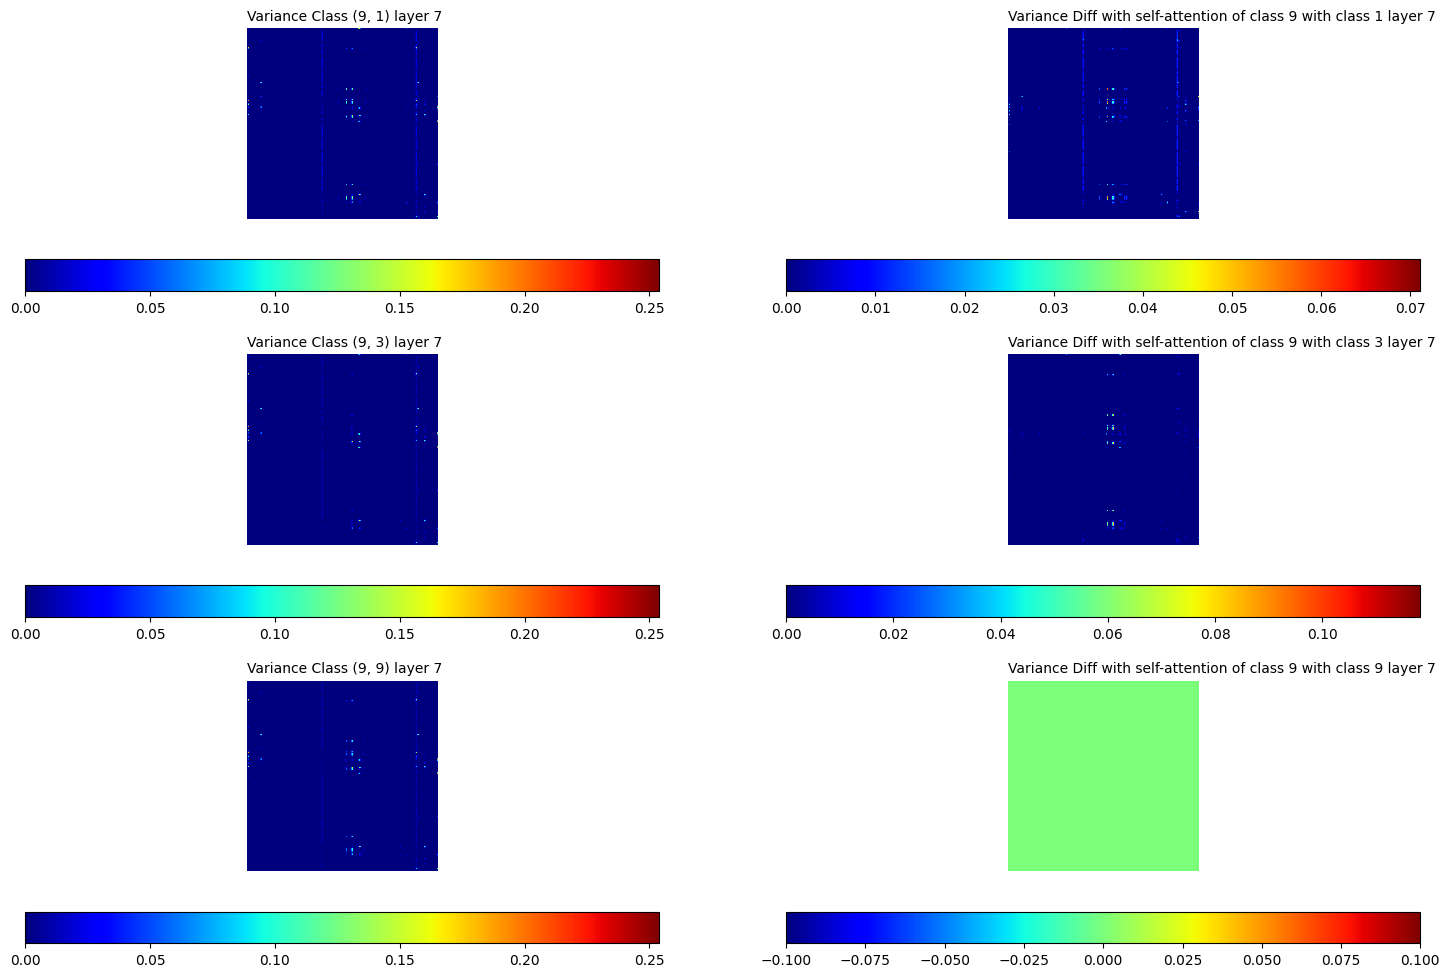

In [35]:
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
att_all = []
for idx, cls in enumerate([(9, 1), (9, 3), (9, 9)]):
    sa_1 = get_attention_from_qkv(
        all_data_dict[cls[0]]["q"],
        all_data_dict[cls[0]]["k"],
    )

    att = get_attention_from_qkv(
        all_data_dict[cls[0]]["q"],
        all_data_dict[cls[1]]["k"],
    )

    x = var_reduce(att)
    y = var_reduce(sa_1)

    att_all.append(x)

    axs[idx, 0].set_title(
        f"Variance Class {cls} layer {MODEL_LAYER}", fontsize=10, loc="left"
    )
    im = axs[idx, 0].imshow(x, cmap="jet")
    plt.colorbar(im, ax=axs[idx, 0], location="bottom")
    axs[idx, 0].axis("off")

    axs[idx, 1].set_title(
        f"Variance Diff with self-attention of class {cls[0]} with class {cls[1]} layer {MODEL_LAYER}",
        fontsize=10,
        loc="left",
    )
    im = axs[idx, 1].imshow(torch.abs(y - x), cmap="jet")
    plt.colorbar(im, ax=axs[idx, 1], location="bottom")
    axs[idx, 1].axis("off")

In [36]:
output_values = []
op_dict = {}
from itertools import combinations_with_replacement

# q-class, k-class, v-class
for idx, cls in enumerate(combinations_with_replacement([1, 3, 9], 2)):
    fxn = torch.var

    att = get_attention_from_qkv(
        all_data_dict[cls[0]]["q"],
        all_data_dict[cls[1]]["k"],
    )
    print(f"Class: {all_data_dict[cls[0]]['label']} and {all_data_dict[cls[1]]['label']}: {fxn(att)}")

    op_dict[cls] = fxn(att)

Class: car and car: 0.005041003227233887
Class: car and cat: 0.00504037830978632
Class: car and truck: 0.005036637652665377
Class: cat and cat: 0.005039826035499573
Class: cat and truck: 0.005035969894379377
Class: truck and truck: 0.005037911236286163


In [37]:
torch.abs(op_dict[(1, 3)] - op_dict[(1, 1)])

tensor(6.2492e-07)